# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_mnist_data

In [4]:
train , test = load_mnist_data(train_transforms,test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

c:\Users\Tharun\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


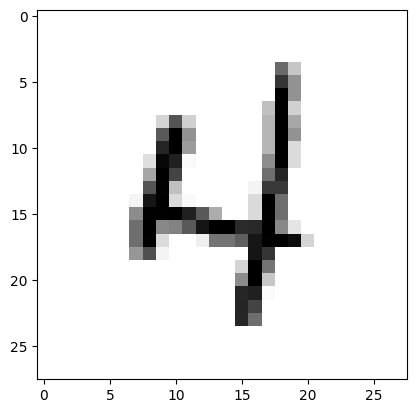

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [7]:
from utils import plot_images

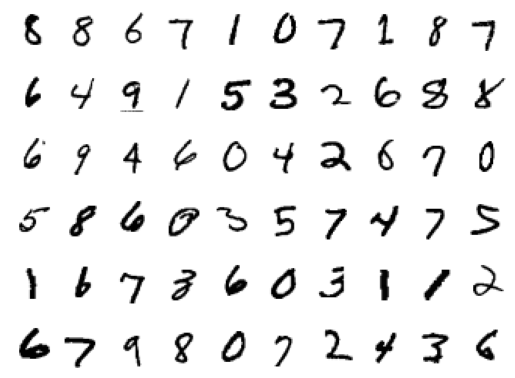

In [8]:
plot_images(images)

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [9]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## The Model [Skeleton Structure]

Let's start with the skeleton structure of the model we decide to move on from here

In [10]:
from model import Model2 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
            Conv2d-2           [-1, 16, 24, 24]           1,152
            Conv2d-3            [-1, 8, 24, 24]             128
         MaxPool2d-4            [-1, 8, 12, 12]               0
            Conv2d-5           [-1, 16, 10, 10]           1,152
            Conv2d-6              [-1, 8, 8, 8]           1,152
            Conv2d-7             [-1, 16, 6, 6]           1,152
            Conv2d-8             [-1, 16, 4, 4]           2,304
         AvgPool2d-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 10, 1, 1]             160
Total params: 7,272
Trainable params: 7,272
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.03
Estimated 

# Training and Testing

All right, so we have 7,272 params. The purpose of this notebook is to set the skeleton structure of our model right.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's import train and test functions from our `model.py` script file

In [12]:
from model import train,test

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch , train_losses , train_acc)
    test(model, device, test_loader ,test_losses , test_acc)

EPOCH: 0


Loss=0.2897312641143799 Batch_id=468 Accuracy=68.55: 100%|██████████| 469/469 [00:07<00:00, 60.86it/s]  



Test set: Average loss: 0.2985, Accuracy: 9089/10000 (90.89%)

EPOCH: 1


Loss=0.264852911233902 Batch_id=468 Accuracy=92.35: 100%|██████████| 469/469 [00:07<00:00, 64.36it/s]    



Test set: Average loss: 0.1689, Accuracy: 9504/10000 (95.04%)

EPOCH: 2


Loss=0.13418824970722198 Batch_id=468 Accuracy=94.79: 100%|██████████| 469/469 [00:07<00:00, 63.24it/s]  



Test set: Average loss: 0.1078, Accuracy: 9675/10000 (96.75%)

EPOCH: 3


Loss=0.07154726982116699 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [00:07<00:00, 63.33it/s]  



Test set: Average loss: 0.1021, Accuracy: 9673/10000 (96.73%)

EPOCH: 4


Loss=0.15084151923656464 Batch_id=468 Accuracy=96.41: 100%|██████████| 469/469 [00:07<00:00, 64.15it/s]  



Test set: Average loss: 0.1059, Accuracy: 9682/10000 (96.82%)

EPOCH: 5


Loss=0.023042067885398865 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:07<00:00, 64.86it/s] 



Test set: Average loss: 0.0852, Accuracy: 9736/10000 (97.36%)

EPOCH: 6


Loss=0.04306308552622795 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:07<00:00, 64.18it/s]  



Test set: Average loss: 0.0730, Accuracy: 9777/10000 (97.77%)

EPOCH: 7


Loss=0.11514555662870407 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]  



Test set: Average loss: 0.0904, Accuracy: 9708/10000 (97.08%)

EPOCH: 8


Loss=0.09696010500192642 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:07<00:00, 63.81it/s]  



Test set: Average loss: 0.0937, Accuracy: 9710/10000 (97.10%)

EPOCH: 9


Loss=0.09677773714065552 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:07<00:00, 63.72it/s]  



Test set: Average loss: 0.0782, Accuracy: 9750/10000 (97.50%)

EPOCH: 10


Loss=0.03281011804938316 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:07<00:00, 64.13it/s]  



Test set: Average loss: 0.0777, Accuracy: 9742/10000 (97.42%)

EPOCH: 11


Loss=0.08227748423814774 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:07<00:00, 63.27it/s]  



Test set: Average loss: 0.0761, Accuracy: 9760/10000 (97.60%)

EPOCH: 12


Loss=0.03980446234345436 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:07<00:00, 64.75it/s]  



Test set: Average loss: 0.0669, Accuracy: 9784/10000 (97.84%)

EPOCH: 13


Loss=0.11417663842439651 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:07<00:00, 64.58it/s]  



Test set: Average loss: 0.0669, Accuracy: 9789/10000 (97.89%)

EPOCH: 14


Loss=0.12675537168979645 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:07<00:00, 64.14it/s]  



Test set: Average loss: 0.0664, Accuracy: 9793/10000 (97.93%)



In [14]:
from model import plot_graphs

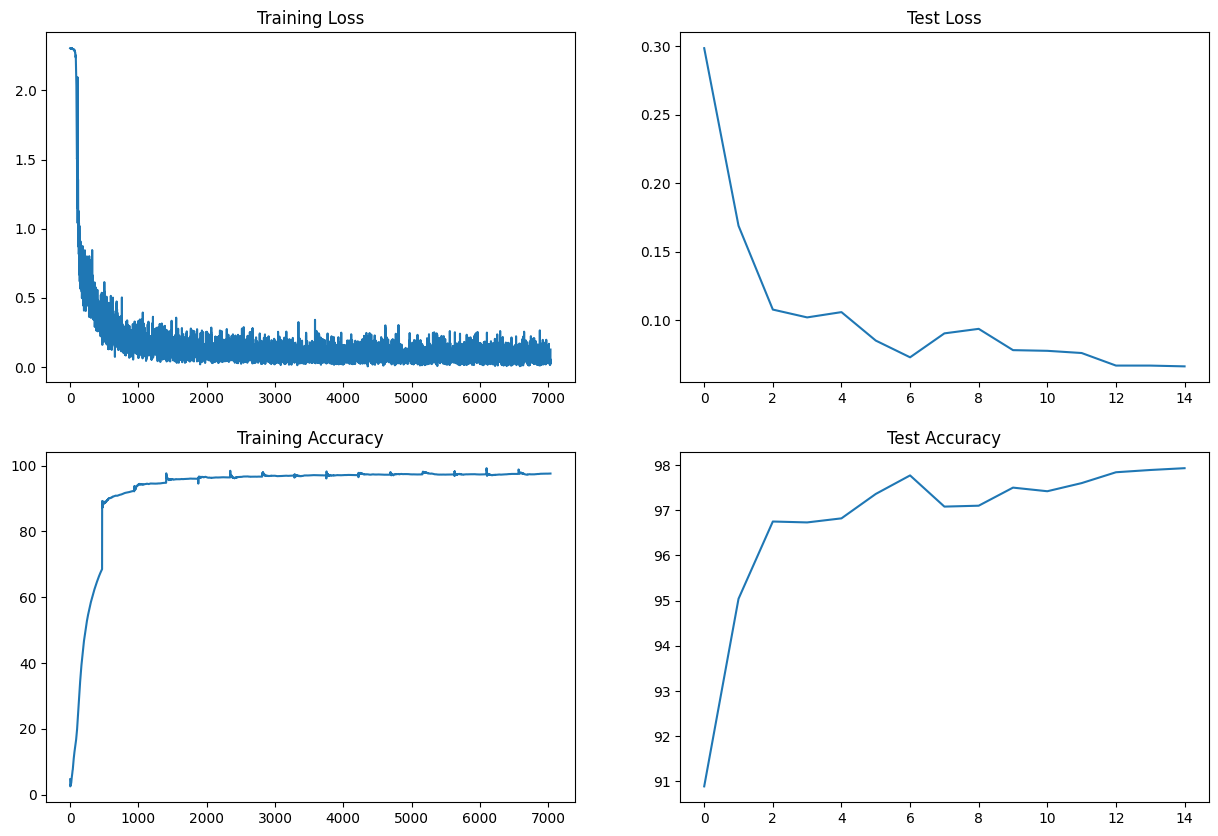

In [15]:
plot_graphs(train_losses , train_acc , test_losses , test_acc)